<a href="https://colab.research.google.com/github/teddy-teem/deep-learning/blob/master/Hyperparameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
torch.manual_seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
file_path = '/content/drive/My Drive/Datasets/dataset-MNIST-fashion/mnist_fashion_train.csv'

In [ ]:
df = pd.read_csv(file_path)
df.shape

(60000, 785)

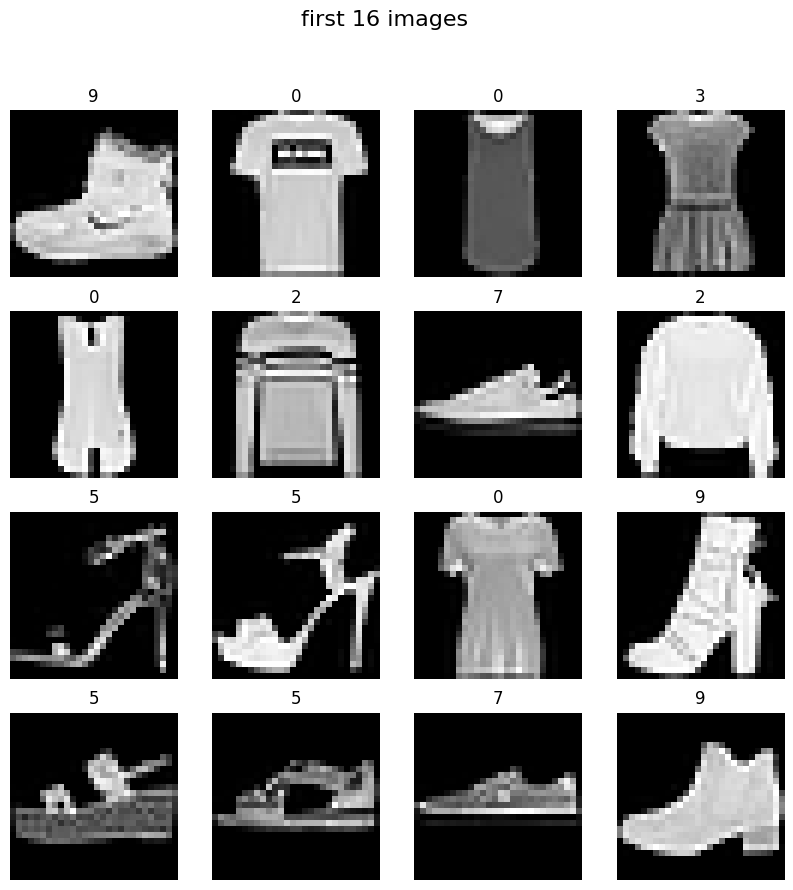

In [ ]:
fig, axes = plt.subplots(4,4, figsize=(10, 10))
fig.suptitle("first 16 images", fontsize=16)

for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28,28)
    ax.axis('off')
    ax.set_title(df.iloc[i, 0])
    ax.imshow(img, cmap='gray')

plt.show()

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# For better tuning, the pixel value should be between 0 to 1 that why we devided by 255 each
X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features =torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

    def __len__(self):
        return len(self.features)

In [ ]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

In [ ]:
class MyNN(nn.Module):
  def __init__(self, input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate):
    super().__init__()

    layers = []
    for i in range(num_hidden_layers):
      layers.append(nn.Linear(input_dim, neurons_per_layer))
      layers.append(nn.BatchNorm1d(neurons_per_layer))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(dropout_rate))
      input_dim = neurons_per_layer
    layers.append(nn.Linear(neurons_per_layer, output_dim))
    self.model = nn.Sequential(*layers)

  def forward(self, x):
    return self.model(x)


In [ ]:
# objective function

def objective(trial):
  # next trial's Hyperparameters values from the search space
  num_hidden_a = trial.suggest_int("num_hidden_layers", 1, 5)
  neurons_per_layer = trial.suggest_int("neurons_per_layer", 8, 128, step=8)
  epochs = trial.suggest_int("epochs", 10, 100, step=10)
  learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
  dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.5, step=0.1)
  batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
  optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
  weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)

  # data loader
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True) # pin_memory=True to speed up the process
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  # model init
  input_dim = 784
  output_dim = 10
  model = MyNN(input_dim, output_dim, num_hidden_a, neurons_per_layer, dropout_rate)
  model.to(device)

  #optimizer selection
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)

  if optimizer_name == "Adam":
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
  elif optimizer_name == "RMSprop":
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-4)
  else:
    optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)

  # training loop
  for epoch in range(epochs):
    total_epoch_loss = 0
    for batch_features, batch_labels in train_loader:
     batch_features = batch_features.to(device)
     batch_labels = batch_labels.to(device)
     out = model(batch_features)
     loss = criterion(out, batch_labels)
     optimizer.zero_grad()
     loss.backward()
     optimizer.step()

     total_epoch_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_epoch_loss/len(train_loader)}")

  # evaluation
  model.eval()
  total = 0
  correct = 0

  with torch.no_grad():
    for batch_features, batch_labels in test_loader:
      batch_features = batch_features.to(device)
      batch_labels = batch_labels.to(device)
      out = model(batch_features)
      _, predicted = torch.max(out.data, 1)
      total += batch_labels.shape[0]
      correct += (predicted == batch_labels).sum().item()

  accuracy=100 * correct / total

  return accuracy

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 20.6 MB/s eta 0:00:00


In [ ]:
import optuna

study = optuna.create_study(direction="maximize")


[I 2025-07-15 17:30:44,791] A new study created in memory with name: no-name-bf3aa9b5-e0fd-499b-91cd-b6987893f67c


In [ ]:
study.optimize(objective, n_trials=50)

Epoch 1, Loss: 0.7782278867562612
Epoch 2, Loss: 0.6410791554848353
Epoch 3, Loss: 0.6176591178973516
Epoch 4, Loss: 0.6062265564997991
Epoch 5, Loss: 0.6052949308951696
Epoch 6, Loss: 0.6039797999461491
Epoch 7, Loss: 0.6032202521165212
Epoch 8, Loss: 0.6032015809218089
Epoch 9, Loss: 0.595425909837087
Epoch 10, Loss: 0.6085987553596497
Epoch 11, Loss: 0.6019191140731176
Epoch 12, Loss: 0.6019335836569468
Epoch 13, Loss: 0.5964481815894445
Epoch 14, Loss: 0.5958421780665716
Epoch 15, Loss: 0.5980685529311498
Epoch 16, Loss: 0.5972554384668668
Epoch 17, Loss: 0.5992592494090399
Epoch 18, Loss: 0.5925921991268793
Epoch 19, Loss: 0.5951510524749756
Epoch 20, Loss: 0.5955349061489105
Epoch 21, Loss: 0.5944489797353745
Epoch 22, Loss: 0.592289040406545
Epoch 23, Loss: 0.5925712291399637
Epoch 24, Loss: 0.5929480526447296
Epoch 25, Loss: 0.5931064592202504
Epoch 26, Loss: 0.5950933369000753
Epoch 27, Loss: 0.5943992225726445
Epoch 28, Loss: 0.5938462136983872
Epoch 29, Loss: 0.5879669995307

[I 2025-07-15 17:33:29,487] Trial 0 finished with value: 83.48333333333333 and parameters: {'num_hidden_layers': 3, 'neurons_per_layer': 64, 'epochs': 70, 'learning_rate': 0.008379743001239661, 'dropout_rate': 0.4, 'batch_size': 64, 'optimizer': 'Adam', 'weight_decay': 1.6487773520205885e-05}. Best is trial 0 with value: 83.48333333333333.


Epoch 1, Loss: 1.68203533522288
Epoch 2, Loss: 1.110332128047943
Epoch 3, Loss: 0.8655115184783936
Epoch 4, Loss: 0.7315633467833201
Epoch 5, Loss: 0.6414402026335398
Epoch 6, Loss: 0.588910197575887
Epoch 7, Loss: 0.5507334023316701
Epoch 8, Loss: 0.5194689134756724
Epoch 9, Loss: 0.4989699157079061
Epoch 10, Loss: 0.4826442914009094
Epoch 11, Loss: 0.4701685107549032
Epoch 12, Loss: 0.4605274725755056
Epoch 13, Loss: 0.44493602856000264
Epoch 14, Loss: 0.4353729114532471
Epoch 15, Loss: 0.42896949529647826
Epoch 16, Loss: 0.4252572671175003
Epoch 17, Loss: 0.41500637884934743
Epoch 18, Loss: 0.4111407713095347
Epoch 19, Loss: 0.40153336675961815
Epoch 20, Loss: 0.40028621125221253
Epoch 21, Loss: 0.39687288530667625
Epoch 22, Loss: 0.3906432868242264
Epoch 23, Loss: 0.38741612728436786
Epoch 24, Loss: 0.38602019123236336
Epoch 25, Loss: 0.3774867013692856
Epoch 26, Loss: 0.3778787015279134
Epoch 27, Loss: 0.37420644696553546
Epoch 28, Loss: 0.36934018894036613
Epoch 29, Loss: 0.36740

[I 2025-07-15 17:35:58,750] Trial 1 finished with value: 88.80833333333334 and parameters: {'num_hidden_layers': 4, 'neurons_per_layer': 72, 'epochs': 100, 'learning_rate': 5.817284058149812e-05, 'dropout_rate': 0.2, 'batch_size': 128, 'optimizer': 'Adam', 'weight_decay': 3.794627897715172e-05}. Best is trial 1 with value: 88.80833333333334.


Epoch 100, Loss: 0.255396359761556
Epoch 1, Loss: 2.4136629158655802
Epoch 2, Loss: 2.366573638598124
Epoch 3, Loss: 2.3332200090090436
Epoch 4, Loss: 2.30971692721049
Epoch 5, Loss: 2.2818051891326903
Epoch 6, Loss: 2.260985142787298
Epoch 7, Loss: 2.237679481903712
Epoch 8, Loss: 2.215232809861501
Epoch 9, Loss: 2.1962071481545764
Epoch 10, Loss: 2.172971254825592
Epoch 11, Loss: 2.1526389748255412
Epoch 12, Loss: 2.13418150806427
Epoch 13, Loss: 2.1133041189511617
Epoch 14, Loss: 2.0908022828102113
Epoch 15, Loss: 2.074731256246567
Epoch 16, Loss: 2.0577516024112703
Epoch 17, Loss: 2.039635686079661
Epoch 18, Loss: 2.023580117146174
Epoch 19, Loss: 2.002714350382487
Epoch 20, Loss: 1.9882828198273976
Epoch 21, Loss: 1.9741148099899293
Epoch 22, Loss: 1.9572885111172993
Epoch 23, Loss: 1.941612559636434
Epoch 24, Loss: 1.931213763554891
Epoch 25, Loss: 1.91318346007665
Epoch 26, Loss: 1.8995763202508291
Epoch 27, Loss: 1.8831851626237233
Epoch 28, Loss: 1.8693916906515757
Epoch 29, L

[I 2025-07-15 17:40:56,939] Trial 2 finished with value: 48.125 and parameters: {'num_hidden_layers': 5, 'neurons_per_layer': 56, 'epochs': 60, 'learning_rate': 0.0001371131333415193, 'dropout_rate': 0.5, 'batch_size': 32, 'optimizer': 'SGD', 'weight_decay': 5.8628045467451346e-05}. Best is trial 1 with value: 88.80833333333334.


Epoch 1, Loss: 2.1402696471214293
Epoch 2, Loss: 1.7433594827651977
Epoch 3, Loss: 1.549862916469574
Epoch 4, Loss: 1.429688747326533
Epoch 5, Loss: 1.3440118475755056
Epoch 6, Loss: 1.2731859405040742
Epoch 7, Loss: 1.2241672022342682
Epoch 8, Loss: 1.1760893087387085
Epoch 9, Loss: 1.1350024768511455
Epoch 10, Loss: 1.1020866539080938
Epoch 11, Loss: 1.0740418504476548
Epoch 12, Loss: 1.0486737167040507
Epoch 13, Loss: 1.0238330425024034
Epoch 14, Loss: 1.0033181219100953
Epoch 15, Loss: 0.9833211713631947
Epoch 16, Loss: 0.9654710116386414
Epoch 17, Loss: 0.946650700767835
Epoch 18, Loss: 0.9321301391124726
Epoch 19, Loss: 0.9166532247463862
Epoch 20, Loss: 0.9057310500542323
Epoch 21, Loss: 0.8939989454348882
Epoch 22, Loss: 0.882178773621718
Epoch 23, Loss: 0.8706949204007784
Epoch 24, Loss: 0.8584521907567978
Epoch 25, Loss: 0.8510625962018966
Epoch 26, Loss: 0.8414546262423197
Epoch 27, Loss: 0.83161649086078
Epoch 28, Loss: 0.8242592129508655
Epoch 29, Loss: 0.817155737777551
E

[I 2025-07-15 17:42:12,906] Trial 3 finished with value: 78.66666666666667 and parameters: {'num_hidden_layers': 1, 'neurons_per_layer': 128, 'epochs': 30, 'learning_rate': 5.083940707389007e-05, 'dropout_rate': 0.5, 'batch_size': 32, 'optimizer': 'SGD', 'weight_decay': 2.5365674345343446e-05}. Best is trial 1 with value: 88.80833333333334.


Epoch 1, Loss: 0.8999913387298584
Epoch 2, Loss: 0.6098714534044266
Epoch 3, Loss: 0.5558935481707256
Epoch 4, Loss: 0.5317393318414688
Epoch 5, Loss: 0.5076516150037448
Epoch 6, Loss: 0.49750906850894294
Epoch 7, Loss: 0.48352980315685273
Epoch 8, Loss: 0.47510433769226074
Epoch 9, Loss: 0.46786819249391554
Epoch 10, Loss: 0.4648853273789088
Epoch 11, Loss: 0.45619684445858
Epoch 12, Loss: 0.4488088257908821
Epoch 13, Loss: 0.4508116141756376
Epoch 14, Loss: 0.44266316546996437
Epoch 15, Loss: 0.43821798849105836
Epoch 16, Loss: 0.4336351941227913
Epoch 17, Loss: 0.4350296621521314
Epoch 18, Loss: 0.42979834268490474
Epoch 19, Loss: 0.4254180289109548
Epoch 20, Loss: 0.4222724462548892
Epoch 21, Loss: 0.4220566095113754
Epoch 22, Loss: 0.4213402707775434
Epoch 23, Loss: 0.41701694564024605
Epoch 24, Loss: 0.41861018085479734
Epoch 25, Loss: 0.4098053230047226
Epoch 26, Loss: 0.4091256971557935
Epoch 27, Loss: 0.41118740713596347
Epoch 28, Loss: 0.4048536069194476
Epoch 29, Loss: 0.403

[I 2025-07-15 17:44:35,991] Trial 4 finished with value: 86.73333333333333 and parameters: {'num_hidden_layers': 1, 'neurons_per_layer': 32, 'epochs': 100, 'learning_rate': 0.01621685816067072, 'dropout_rate': 0.30000000000000004, 'batch_size': 64, 'optimizer': 'SGD', 'weight_decay': 0.00032157629766401574}. Best is trial 1 with value: 88.80833333333334.


Epoch 1, Loss: 0.8915095737377803
Epoch 2, Loss: 0.6288092111249765
Epoch 3, Loss: 0.5849453803201516
Epoch 4, Loss: 0.5604249959588051
Epoch 5, Loss: 0.5421941731174786
Epoch 6, Loss: 0.5245662169158458
Epoch 7, Loss: 0.5165016142725944
Epoch 8, Loss: 0.5095216555595398
Epoch 9, Loss: 0.504663629492124
Epoch 10, Loss: 0.4884319495558739
Epoch 11, Loss: 0.49185765970746675
Epoch 12, Loss: 0.48190040797988576
Epoch 13, Loss: 0.48181168217460313
Epoch 14, Loss: 0.47501459665596485
Epoch 15, Loss: 0.47181904727220536
Epoch 16, Loss: 0.4675127329727014
Epoch 17, Loss: 0.4668754889965057
Epoch 18, Loss: 0.46596985443433125
Epoch 19, Loss: 0.4602501332362493
Epoch 20, Loss: 0.45425656329095365
Epoch 21, Loss: 0.4562406214972337
Epoch 22, Loss: 0.4524307096699874
Epoch 23, Loss: 0.45336666694283484
Epoch 24, Loss: 0.4514449192037185
Epoch 25, Loss: 0.4460394856631756
Epoch 26, Loss: 0.4485663784344991
Epoch 27, Loss: 0.4457905806154013
Epoch 28, Loss: 0.44647400175035
Epoch 29, Loss: 0.442587

[I 2025-07-15 17:50:50,943] Trial 5 finished with value: 87.81666666666666 and parameters: {'num_hidden_layers': 3, 'neurons_per_layer': 48, 'epochs': 90, 'learning_rate': 0.0006938451508248465, 'dropout_rate': 0.30000000000000004, 'batch_size': 32, 'optimizer': 'Adam', 'weight_decay': 4.1513255582650815e-05}. Best is trial 1 with value: 88.80833333333334.


Epoch 1, Loss: 1.7704097566604615
Epoch 2, Loss: 1.5208694764773052
Epoch 3, Loss: 1.4778862462838491
Epoch 4, Loss: 1.4569678584734598
Epoch 5, Loss: 1.4176298650105794
Epoch 6, Loss: 1.4151618213653565
Epoch 7, Loss: 1.406294753630956
Epoch 8, Loss: 1.4186855211257934
Epoch 9, Loss: 1.39974138434728
Epoch 10, Loss: 1.4087440139452616
Epoch 11, Loss: 1.4186006995836893
Epoch 12, Loss: 1.4133282214800518
Epoch 13, Loss: 1.4392187019983926
Epoch 14, Loss: 1.4272698621749877
Epoch 15, Loss: 1.4188706115086873
Epoch 16, Loss: 1.4055766917069754
Epoch 17, Loss: 1.4011516040166219
Epoch 18, Loss: 1.403233081181844
Epoch 19, Loss: 1.4175549171765645
Epoch 20, Loss: 1.4074244662920634
Epoch 21, Loss: 1.4028165767987568
Epoch 22, Loss: 1.4126538048585255
Epoch 23, Loss: 1.4178093260129292
Epoch 24, Loss: 1.4045551280975341
Epoch 25, Loss: 1.4140630427201588
Epoch 26, Loss: 1.4087290824254355
Epoch 27, Loss: 1.4142375276883443
Epoch 28, Loss: 1.4246920496622721
Epoch 29, Loss: 1.409232001463572

[I 2025-07-15 17:54:08,575] Trial 6 finished with value: 54.65 and parameters: {'num_hidden_layers': 5, 'neurons_per_layer': 96, 'epochs': 70, 'learning_rate': 0.0565050609280268, 'dropout_rate': 0.5, 'batch_size': 64, 'optimizer': 'RMSprop', 'weight_decay': 9.574671933622558e-05}. Best is trial 1 with value: 88.80833333333334.


Epoch 1, Loss: 0.9627239445050557
Epoch 2, Loss: 0.7522825832366944
Epoch 3, Loss: 0.728454260190328
Epoch 4, Loss: 0.7109876887003581
Epoch 5, Loss: 0.7028116117318471
Epoch 6, Loss: 0.6927333190441132
Epoch 7, Loss: 0.6898318702379862
Epoch 8, Loss: 0.6881693137486776
Epoch 9, Loss: 0.6836293772856394


[I 2025-07-15 17:54:22,777] Trial 7 finished with value: 82.36666666666666 and parameters: {'num_hidden_layers': 4, 'neurons_per_layer': 80, 'epochs': 10, 'learning_rate': 0.009746061997760468, 'dropout_rate': 0.5, 'batch_size': 128, 'optimizer': 'RMSprop', 'weight_decay': 4.5506047118325213e-05}. Best is trial 1 with value: 88.80833333333334.


Epoch 10, Loss: 0.6778009703159332
Epoch 1, Loss: 2.2575606956481935
Epoch 2, Loss: 2.1386311683654786
Epoch 3, Loss: 2.059745486895243
Epoch 4, Loss: 1.9988887519836427
Epoch 5, Loss: 1.9534305159250895
Epoch 6, Loss: 1.9140985940297444
Epoch 7, Loss: 1.8854332898457844
Epoch 8, Loss: 1.8560812877019246
Epoch 9, Loss: 1.8319835920333862
Epoch 10, Loss: 1.8055233373641968
Epoch 11, Loss: 1.78498104763031
Epoch 12, Loss: 1.7631713717778523
Epoch 13, Loss: 1.7440631062189738
Epoch 14, Loss: 1.7246189279556274
Epoch 15, Loss: 1.7066784524917602
Epoch 16, Loss: 1.68837260278066
Epoch 17, Loss: 1.67284393119812
Epoch 18, Loss: 1.6538245843251547
Epoch 19, Loss: 1.6383330039978028
Epoch 20, Loss: 1.6253142601648967
Epoch 21, Loss: 1.60596799437205
Epoch 22, Loss: 1.5912307856877645
Epoch 23, Loss: 1.5766896006266276
Epoch 24, Loss: 1.5621441532770792
Epoch 25, Loss: 1.548713591893514
Epoch 26, Loss: 1.5379614505767822
Epoch 27, Loss: 1.5235387630462647
Epoch 28, Loss: 1.5107482233047484
Epoc

[I 2025-07-15 17:54:54,784] Trial 8 finished with value: 69.49166666666666 and parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 40, 'epochs': 30, 'learning_rate': 8.035186090204443e-05, 'dropout_rate': 0.2, 'batch_size': 128, 'optimizer': 'SGD', 'weight_decay': 3.1010295455822646e-05}. Best is trial 1 with value: 88.80833333333334.


Epoch 30, Loss: 1.4863474537531536
Epoch 1, Loss: 0.9810717425942421
Epoch 2, Loss: 0.725169744938612
Epoch 3, Loss: 0.6590540001938741
Epoch 4, Loss: 0.6219125208432476
Epoch 5, Loss: 0.5897999877432982
Epoch 6, Loss: 0.5795014652659496
Epoch 7, Loss: 0.5679007366498311
Epoch 8, Loss: 0.5498361547514796
Epoch 9, Loss: 0.5403701269105077
Epoch 10, Loss: 0.5249688339109222


[I 2025-07-15 17:56:18,153] Trial 9 finished with value: 86.84166666666667 and parameters: {'num_hidden_layers': 4, 'neurons_per_layer': 128, 'epochs': 10, 'learning_rate': 0.014432972238741631, 'dropout_rate': 0.4, 'batch_size': 16, 'optimizer': 'SGD', 'weight_decay': 1.5424994640731916e-05}. Best is trial 1 with value: 88.80833333333334.


Epoch 1, Loss: 2.286612787246704
Epoch 2, Loss: 2.2009249267578124
Epoch 3, Loss: 2.151641866048177
Epoch 4, Loss: 2.107329005877177
Epoch 5, Loss: 2.065323424975077
Epoch 6, Loss: 2.0278420095443725


[W 2025-07-15 17:56:28,501] Trial 10 failed with parameters: {'num_hidden_layers': 4, 'neurons_per_layer': 16, 'epochs': 90, 'learning_rate': 1.3378360208554625e-05, 'dropout_rate': 0.2, 'batch_size': 128, 'optimizer': 'Adam', 'weight_decay': 0.0003000014016951423} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipython-input-20-1962216220.py", line 38, in objective
    for batch_features, batch_labels in train_loader:
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 704, in __next__
    with torch.autograd.profiler.record_function(self._profile_name):
  File "/usr/local/lib/python3.11/dist-packages/torch/autograd/profiler.py", line 769, in __exit__
    torch.ops.profiler._record_function_exit._RecordFunction(record)
  File "/usr/lo

Epoch 7, Loss: 1.9926121775309245


KeyboardInterrupt: 

In [ ]:
study.best_value

88.80833333333334

In [ ]:
study.best_params

{'num_hidden_layers': 4,
 'neurons_per_layer': 72,
 'epochs': 100,
 'learning_rate': 5.817284058149812e-05,
 'dropout_rate': 0.2,
 'batch_size': 128,
 'optimizer': 'Adam',
 'weight_decay': 3.794627897715172e-05}